In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from scipy.optimize import curve_fit
import os

#Abundance richiede 9 colonne, in ordine
#1) Wavelenght (angstrom)
#2) elemento.ionizzazione "species code"
#3) energia potenziale lower state (cm^-1)
#4) energia upper states (cm^-1)
#5) log(gf)
#6) fudge factor (per broadening Van der Waals)
#7) tipo di transizione (99 per defaul se non c'è specificato nella linelist o se la transizione è più complessa o transizione molecolare)
#8) Equivalent Width in mA
#9) Fonte del dato (e.g. NIST = National Institute of Standards and Technology)
#
#ARES vuole
#colonna con lunghezze d'onda
#ARES fornisce
#1) wavelenght (angstrom)
#2) numero di linee fittate per il risultato
#3) profondità della riga
#4) FWHM della riga
#5) Equivalent Width della riga
#6) Errore sulla EW
# le ultime 3 sono i coefficienti delle gaussiane per fittare
#7) profondità
#8) sigma
#9) centro
#

#SE le wavelenght sono letteralmente le stesse nei due file (linelist di luke.lst di spectrum e linelist.dat\test.ares di ARES) 
#è sufficiente prendere i dati da luke, individuare le stesse righe e inserire la colonna delle EW da ARES. Altrimenti mi
#metto a piangere

#Per far crescere l'abbondanza del FeII bisogna DIMINUIRE il logg











#problemi: 
# 1) l'interpolatore crea atmosfere che danno risultati diversi dalle atmosfere di Franchini a parità di parametri.










In [60]:
################## DEFINIZIONI FUNZIONI E VARIABILI UTILI ###################


####
path_to_linemake = f"/home/starcat/LINEE"
path_to_ARES = f"/home/starcat/Modelli/ARES-master"
path_to_abundance = f"/home/starcat/Scrivania/ANALISIATM/spectrum277c/"
path_to_atmosphere = f"/home/starcat/Scrivania/ANALISIATM/ATMOSFERE/"
path_to_rnd = f"/home/starcat/Scrivania/ANALISIATM/rnd"
path_to_output = f"/home/starcat/Scrivania/ANALISIATM/ABBONDANZE_OUT/"
path_to_interpol = f"/home/starcat/Scrivania/ANALISIATM/interpol/PyKMOD-main/"
####

trials = 30
temp_log = np.zeros(trials)
logg_log = np.zeros(trials)
T_slope = np.zeros((trials, 2))
Logg_slope = np.zeros((trials, 2))
temp_best_guess1 = 0
temp_best_guess2 = 0
temp_best_guess3 = 0
temperatura = [3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000, 12250, 12500, 12750, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000]
logg_arr = [0, 0.50000, 1.00000, 1.50000, 2.00000, 2.50000, 3.00000, 3.50000, 4.00000, 4.50000, 5.00000]
MH = ["05", "02", "00", "-05", "-10", "-15", "-20"]
metallicity = ["0.5", "0.2", "0.0", "-0.5", "-1.0", "-1.5", "-2.0", "-2.5"]
metallic = [0.5, 0.2, 0.0, -0.5, -1.0, -1.5, -2.0, -2.5]
T_EFF_int = np.arange(3500, 5500 + 1, 25)
LOGG_int = np.arange(0.5, 5 + 0.06, 0.05)
MH_int = np.arange(0.0, -3.0 - 0.06, -0.05)
T_EFF_Nint = np.arange(3500, 5500 + 1, 250)
LOGG_Nint = np.arange(0.5, 5 + 0.06, 0.5)
MH_Nint = np.arange(0.0, -3.0 - 0.06, -0.5)

ABUNDANCE_SCALE = [3.16228, 1.58489, 1.00000, 0.31620, 0.10000, 0.03162, 0.01000, 0.00316]


def func(x, a, b):
    return b +a*x
def guessAtmosphere_fromT(T1, T2, log, MHX):
    os.chdir(path_to_output)
    t1 = Table.read('stellaFes', format='ascii')
    t2 = Table.read(f'PINOLOS{MHX}{int(T1)}{log}',format='ascii')
    t3 = Table.read(f'PINOLOS{MHX}{int(T2)}{log}',format='ascii')
    eqw=t1['col8']
    tag=t1['col9']
    col_eqw = Table.Column(name='eqw', data=eqw)
    col_tag = Table.Column(name='tag', data=tag)
    # t2.add_column(col_eqw)
    # t2.add_column(col_tag)
    # t3.add_column(col_eqw)int
    # t3.add_column(col_tag)
    x2=t2['col3']
    y2=t2['col7']
    #z2=t2['eqw']
    fe=t2['col2']
    x3=t3['col3']
    y3=t3['col7']
    #z3=t3['eqw']
    fe=t3['col2']
    limit=((fe==26.0))
    x2=x2[limit]
    y2=y2[limit]
    x3=x3[limit]
    y3=y3[limit]
    popt2, pcov2 = curve_fit(func, x2, y2,method='lm')
    popt3, pcov3 = curve_fit(func, x3, y3,method='lm')
    weight = (popt3[0]/(popt3[0] - popt2[0]))
    print(weight)
    return T1*weight + T2*(1-weight)
def guessAtmosphere_fromTf(T1, T2, log1, log2, MHX):
    os.chdir(path_to_output)
    t1 = Table.read('stellaFes', format='ascii')
    t2 = Table.read(f'PINOLOS{MHX}{int(T1)}{log1}',format='ascii')
    t3 = Table.read(f'PINOLOS{MHX}{(T2)}{log2}',format='ascii')
    eqw=t1['col8']
    tag=t1['col9']
    col_eqw = Table.Column(name='eqw', data=eqw)
    col_tag = Table.Column(name='tag', data=tag)
    # t2.add_column(col_eqw)
    # t2.add_column(col_tag)
    # t3.add_column(col_eqw)int
    # t3.add_column(col_tag)
    x2=t2['col3']
    y2=t2['col7']
    #z2=t2['eqw']
    fe=t2['col2']
    x3=t3['col3']
    y3=t3['col7']
    #z3=t3['eqw']
    fe=t3['col2']
    limit=((fe==26.0))
    x2=x2[limit]
    y2=y2[limit]
    x3=x3[limit]
    y3=y3[limit]
    popt2, pcov2 = curve_fit(func, x2, y2,method='lm')
    popt3, pcov3 = curve_fit(func, x3, y3,method='lm')
    weight = (popt3[0]/(popt3[0] - popt2[0]))
    print(weight)
    return T1*weight + T2*(1-weight)
def guessAtmosphere_fromLogg(L1, L2, TEMPERATURA, MHX):
    os.chdir(path_to_output)
    t1 = Table.read('stellaFes', format='ascii')
    t2 = Table.read(f'PINOLOS{MHX}{int(TEMPERATURA)}{L1}',format='ascii')
    t3 = Table.read(f'PINOLOS{MHX}{int(TEMPERATURA)}{L2}',format='ascii')
    eqw=t1['col8']
    tag=t1['col9']
    col_eqw = Table.Column(name='eqw', data=eqw)
    col_tag = Table.Column(name='tag', data=tag)
    # t2.add_column(col_eqw)
    # t2.add_column(col_tag)
    # t3.add_column(col_eqw)
    # t3.add_column(col_tag)
    x2=t2['col3']
    y2=t2['col7']
    X2=t2['col3']
    Y2=t2['col7']
    #z2=t2['eqw']
    fe=t2['col2']
    x3=t3['col3']
    y3=t3['col7']
    X3=t3['col3']
    Y3=t3['col7']
    #z3=t3['eqw']
    fe=t3['col2']
    limit=((fe==26.0))
    x2=x2[limit]
    y2=y2[limit]
    limit=((fe==26.1))
    X2=X2[limit]
    Y2=Y2[limit]
    limit=((fe==26.0))
    x3=x3[limit]
    y3=y3[limit]
    limit=((fe==26.1))
    X3=X3[limit]
    Y3=Y3[limit]
    media1 = np.mean(y2)-np.mean(Y2)
    media2 = np.mean(y3)-np.mean(Y3)
    weight = media2/(media2 - media1)
    print(weight)
    return L1*weight + L2*(1-weight)
def crea_ATMinterpol(T, logg, MH_g): #ritorna il nome del file prodotto da abundance con l'atmosfera creata tramite interpolazione
    os.chdir(path_to_interpol)
    vturb = 0.14 - 0.08 * (MH_g) + 4.9 * T / 10000 - 0.47 * logg

    commandInterpol = f"/home/starcat/anaconda/bin/python pykmod.py {T} {logg} {vturb} {MH_g}"
    print(vturb)
    os.system(commandInterpol)

    #### FORMATTA KURUCZ ####
    header1 = f"TEFF   {T}.  GRAVITY {logg} LTE\nTITLE  [{MH_g}] VTURB={vturb}  L/H=1.25 NOVER NEW ODF\n"
    header2 = " OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   0.03162 ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
    tail = "PRADK 5.4502E-01\nBEGIN                    ITERATION  15 COMPLETED"

    def read_and_copy_file(input_file, output_file, header1, header2, lines, tail):
        with open(input_file, 'r') as f_in:
            lines = f_in.readlines()

        # Remove the first 3 rows and the last 2 rows
        lines = lines[3:-2]

        with open(output_file, 'w') as f_out:
            f_out.write(header1)
            f_out.write(header2)
            f_out.writelines(lines)
            f_out.write(tail)

    read_and_copy_file('modelatmosphere.txt', 'out.txt')
    comandoATMOS = f"cp {path_to_interpol}out.txt {path_to_abundance}/ModelE"
    os.system(comandoATMOS)
    os.chdir(path_to_abundance)
    with open('param.txt', 'w') as paramfile:
        paramfile.write(f'ATMname ModelE\nLINESname stellaFes\nOUTname PINOLOS\nvturb {str(vturb)}')
    
    ! ./abundance -t
    nome_output = f"STELLA_INT{MH_g}{T}{logg}"
    comando_bsh2 = f"mv PINOLOS {path_to_output}/{nome_output}"
    print("A5")
    os.system(comando_bsh2)
    print("B5")
    return nome_output
def sposta(nome_oggetto, path_oggetto, path_destinazione, nome_oggetto_destinazione):
    COMANDO = f"mv {path_oggetto}/{nome_oggetto} {path_destinazione}/{nome_oggetto_destinazione}"
    os.system(COMANDO)
def copia(nome_oggetto, path_oggetto, path_destinazione, nome_oggetto_destinazione):
    COMANDO = f"cp {path_oggetto}/{nome_oggetto} {path_destinazione}/{nome_oggetto_destinazione}"
    os.system(COMANDO)
def vturbo(T, LG, Met):
    return 0.14 - 0.08 * (Met) + 4.9 * T / 10000 - 0.47 * LG
def creaParamfileAbnd(microturb):
    with open('param.txt', 'w') as paramfile:
        paramfile.write(f'ATMname ModelE\nLINESname stellaFes\nOUTname PINOLOS\nvturb {str(microturb)}')
        sposta('param.txt', os.getcwd(), path_to_abundance, 'param.txt')
def lanciaAbundance():
    DIR_INI = os.getcwd()
    os.chdir(path_to_abundance)
    ! ./abundance -t
    os.chdir(DIR_INI)    
def simpleAnalysisSingle(path_file, nome_file, elemento):
    DIR_INI = os.getcwd()
    os.chdir(path_file)
    returner = np.zeros(3)
    t1 = Table.read('stellaFes', format='ascii')
    t2 = Table.read(nome_file, format='ascii')
    x=t2['col3']
    y=t2['col7']
    fe=t2['col2']
    limit=((fe==elemento))
    x=x[limit]
    y=y[limit]
    limit=((y<np.mean(y)+1*np.std(y))&(y>np.mean(y)-1*np.std(y)))
    x=x[limit]
    y=y[limit]
    popt, pcov = curve_fit(func, x, y,method='lm')
    std1=np.std(y-(func(x,*popt)))
    #print(f"deviazione standard = {std1}")
    os.chdir(DIR_INI)
    returner[0] = np.mean(y) #media
    returner[1] = popt[0]    #slope
    returner[2] = std1       #std
    return returner
def simpleAnalysisDouble(path_file, nome_file, elemento1, elemento2):
    DIR_INI = os.getcwd()
    os.chdir(path_file)
    returner = np.zeros(2)
    t1 = Table.read('stellaFes', format='ascii')
    t2 = Table.read(nome_file, format='ascii')
    t3 = Table.read(nome_file, format='ascii')
    x2=t2['col3']
    y2=t2['col7']
    fe2=t2['col2']
    limit=((fe2==elemento1))
    x2=x2[limit]
    y2=y2[limit]
    limit=((y2<np.mean(y2)+1*np.std(y2))&(y2>np.mean(y2)-1*np.std(y2)))
    x2=x2[limit]
    y2=y2[limit]
    x3=t3['col3']
    y3=t3['col7']
    fe3=t3['col2']
    limit=((fe3==elemento2))
    x3=x3[limit]
    y3=y3[limit]
    limit=((y3<np.mean(y3)+1*np.std(y3))&(y3>np.mean(y3)-1*np.std(y3)))
    x3=x3[limit]
    y3=y3[limit]
    os.chdir(DIR_INI)
    returner[0] = np.mean(y2) #abbondanza elemento1
    returner[1] = np.mean(y3) #abbondanza elemento2
    return returner
def findAbundance(tempera, logG, metal, multiple_elements=0,  elemento1=26.0, elemento2=26.1):
    copia(f"atmoT{int(tempera)}{logG}.txt", path_to_atmosphere + f"MH{metal}", path_to_abundance, "ModelE") #metti il file dell'atmosfera dentro la cartella di abundance
    creaParamfileAbnd(vturbo(tempera, logG, metal))  #fai paramfile di abundance
    lanciaAbundance()                                    #lancia abundance
    sposta("PINOLOS", path_to_abundance, path_to_output, f"STELLA{metal}_{tempera}_{logG}") #copia l'output di abundance nella cartella degli output
    if multiple_elements == 0:
        results = simpleAnalysisSingle(path_to_output, f"STELLA{metal}_{tempera}_{logG}", elemento1)
    else:
        results = simpleAnalysisDouble(path_to_output, f"STELLA{metal}_{tempera}_{logG}", elemento1, elemento2)
    return results
def iterative_temperatureSearch(tempera, logG, metal, trials=15, elemento=26.0, controller=1):
    diarioTemp = np.zeros((trials, 4))
    i=0
    min = 1000
    while controller==1:
        print(f"trial = {i}")
        A = findAbundance(tempera, logG, metal, 0, elemento)
        diarioTemp[i][0] = A[0]
        diarioTemp[i][1] = A[1]
        diarioTemp[i][2] = A[2]
        diarioTemp[i][3] = tempera
        required_index = 0
        for k in range(trials):
            if (k!=i) and (diarioTemp[k][3]==diarioTemp[i][3]):
                controller = 0
        if ((tempera > 3499) and (tempera < 12750)): 
            if (diarioTemp[i][1]>0):
                tempera = tempera + 250
                tempera = int(tempera)
            else:
                if tempera > 3749:
                    tempera = tempera - 250
                    tempera = int(tempera)
        i=i+1
    if controller == 1:
        print("il numero di trials non è stato sufficiente ad ottenere un risultato, prova con un numero di trials maggiore")
    if controller == 0:
        for j in range(trials):
            if (diarioTemp[j][3] != 0) and (abs(diarioTemp[j][1]) < abs(min)):
                min = diarioTemp[j][1]
                required_index = j
        print(f"la temperatura {diarioTemp[required_index][3]} è il valore più vicino a quello cercato \ncorrispondente a una slope di {diarioTemp[required_index][1]} \nl'abbondanza dell'elemento {elemento} è di {diarioTemp[required_index][0]} +- {diarioTemp[required_index][2]}")
        returner = np.zeros(4)
        returner[0] = diarioTemp[required_index][0]
        returner[1] = diarioTemp[required_index][1]
        returner[2] = diarioTemp[required_index][2]
        returner[3] = diarioTemp[required_index][3]
        return returner
def iterative_logGSearch(tempera, logG, metal, trials=15, elemento=26.0, controller=1):
    diarioLogG = np.zeros((trials, 3))
    diarioLogG = diarioLogG + 555.9
    i=0
    min = 1000
    while controller==1:
        print(f"trial = {i}")
        outPut = findAbundance(tempera, logG, metal, 1, 26.0, 26.1)
        diarioLogG[i][0] = outPut[0]
        diarioLogG[i][1] = outPut[1]
        diarioLogG[i][2] = logG
        required_index = 0
        for k in range(trials):
            if (k!=i) and (diarioLogG[k][2]==diarioLogG[i][2]):
                controller = 0
        if ((logG > -0.1) and (logG < 5.1)): 
            if (diarioLogG[i][0] - diarioLogG[i][1] > 0):
                logG = logG + 0.5
            else:
                if logG > 0.4:
                    logG = logG - 0.5
        print(f"{diarioLogG[i][0]-diarioLogG[i][1]} con {diarioLogG[i][2]}")
        i=i+1
    if controller == 1:
        print("il numero di trials non è stato sufficiente ad ottenere un risultato, prova con un numero di trials maggiore")
    if controller == 0:
        for j in range(i):
            if abs(diarioLogG[j][1]-diarioLogG[j][0]) < abs(min):
                min = (diarioLogG[j][0]-diarioLogG[j][1])
                required_index = j
        print(f"il logG {diarioLogG[required_index][2]} è il valore più vicino a quello cercato \ncorrispondente a una slope di {diarioLogG[required_index][1]} \nl'abbondanza dell'elemento {elemento} è di {diarioLogG[required_index][0]} +- {diarioLogG[required_index][2]}")
        returner = np.zeros(3)
        returner[0] = diarioLogG[required_index][0]
        returner[1] = diarioLogG[required_index][1]
        returner[2] = diarioLogG[required_index][2] #logG cercata
        return returner
def creaOptFileARES(specfits='Stello.fits', readlinedat='Iron_lines', fileout='stella.ares', lambdai="4600.", lambdaf="6700.", smoothder="4", space="3.0", rejt="3;5764,5766,6047,6052,6068,6076", lineresol="0.1", miniline="2", plots_flag="0", rvmask="3,6021.8,6024.06,6027.06,6024.06,20"):
    with open('mine.opt', 'w') as paramfile:
        paramfile.write(f'specfits=\'{specfits}\'\nreadlinedat=\'{readlinedat}\'\nfileout=\'{fileout}\'\nlambdai={lambdai}\nlambdaf={lambdaf}\nsmoothder={smoothder}\nspace={space}\nrejt={rejt}\nlineresol={lineresol}\nminiline={miniline}\nplots_flag={plots_flag}\nrvmask=\'{rvmask}\'')
def parameterAnalysis(param_space_directions, T_center, log_center, M_center, T_steps=50, log_steps=0.1, M_steps=0.1, T_tot=8, log_tot=8, M_tot=10):
    if (param_space_directions < 1) or (param_space_directions>4):
        print("Il primo argomento in parameterAnalysis deve essere un int \n1 - muoviti solo in temperatura\n2 - muoviti in temperatura e logg\n3 - muoviti in temperatura logg e metallicità\n4 muoviti solo in logg")
    elif param_space_directions == 1:
        T = T_center - (T_steps*T_tot)/2
        T_temp = T
        ### muovi temperatura
        for i in range(T_tot):
            crea_ATMinterpol(round(T_temp), round(log_center, 1), round(M_center, 2))                
            T_temp = T_temp + T_steps
    elif param_space_directions == 2:
        T = T_center - (T_steps*T_tot)/2
        log = log_center - (log_steps*log_tot)/2
        T_temp = T
        log_temp = log
        ### muovi temperatura e al suo interno il logg
        for i in range(T_tot):
            for j in range(log_tot):
                crea_ATMinterpol(round(T_temp), round(log_temp, 1), round(M_center, 2))
                log_temp = log_temp + log_steps
            T_temp = T_temp + T_steps
            log_temp = log
    elif param_space_directions == 3:
        T = T_center - (T_steps*T_tot)/2
        log = log_center - (log_steps*log_tot)/2
        M = M_center - (M_steps*T_tot)/2
        T_temp = T
        log_temp = log
        M_temp = M
        ### muovi temperatura e al suo interno il logg
        for i in range(T_tot):
            for j in range(log_tot):
                for k in range(M_tot):
                    crea_ATMinterpol(round(T_temp), round(log_temp, 1), round(M_temp, 2))
                    M_temp = M_temp + M_steps
                log_temp = log_temp + log_steps
                M_temp = M
            T_temp = T_temp + T_steps
            log_temp = log
    print("FINITO DEBOE")
def find_closest(num, arr):
    arr = np.array(arr)
    closest_index = np.abs(arr - num).argmin()
    return arr[closest_index]
def write_file(output_file, header1, header2, lines, tail):
        with open(output_file, 'w') as f_out:
            f_out.write(header1)
            f_out.write(header2)
            f_out.writelines(lines)
            f_out.write(tail)
def rimuoviHeader_atm(input_file, input_path, output_file, output_path):
    A=(os.getcwd())
    os.chdir(input_path)
    with open(input_file, 'r') as filein:
        lines = filein.readlines()
    lines = lines[23:-2]
    os.chdir(output_path)
    with open(output_file, 'w') as fileout:
        fileout.writelines(lines)
    os.chdir(A)
def interpolaT(T, logg, M, path_ATM=path_to_atmosphere):
    P=[]
    linea = []
    T=find_closest(T, T_EFF_int)
    logg=find_closest(logg, LOGG_Nint)
    M=find_closest(M, MH_Nint)
    vturbs = vturbo(T, logg, M)
    header1 = f"TEFF   {T}.  GRAVITY {logg:.1f} LTE\nTITLE  [{M:.1f}] VTURB={vturbs}  L/H=1.25 NOVER NEW ODF\n"
    header2 = " OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   0.10000 ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
    tail = "PRADK 5.4502E-01\nBEGIN                    ITERATION  15 COMPLETED"
    os.chdir(path_to_atmosphere + f"MH{M:.1f}")
    for i in range(len(T_EFF_Nint)):
        nomeATMint = f'T{T_EFF_Nint[i]}{logg:.1f}.int'
        copia(f'atmoT{T_EFF_Nint[i]}{logg:.1f}.txt', os.getcwd(), os.getcwd(), nomeATMint)
        rimuoviHeader_atm(nomeATMint, os.getcwd(), nomeATMint, os.getcwd())
        P.append(Table.read(f'T{T_EFF_Nint[i]}{logg:.1f}.int', format='ascii'))
    y = np.zeros((72, 10))
    for i in range(72):
        for j in range(10):
            a=[]
            for k in range(len(T_EFF_Nint)):
                a.append((P[k])[i][j])
            z = np.polyfit(T_EFF_Nint, np.asarray(a), 6)
            f = np.poly1d(z)
            x_new = np.linspace(T_EFF_int[0], T_EFF_int[-1], len(T_EFF_Nint)*1000)
            y_new = f(x_new)
            T = find_closest(T, x_new)
            indice = np.where(x_new == T)[0]
            y[i][j] = y_new[indice]
        linea.append(f" {y[i][0]:.8E}   {y[i][1]:.1f} {y[i][2]:.3E} {y[i][3]:.3E} {y[i][4]:.3E} {y[i][5]:.3E} {y[i][6]:.3E} {y[i][7]:.3E} {y[i][8]:.3E} {y[i][9]:.3E}\n")
    nome_out = f'atm{T:.0f}_{logg}.int'
    write_file( nome_out, header1, header2, linea, tail)
    sposta( nome_out, os.getcwd(), path_to_output, nome_out)
    return P
#adesso devo usare questi valori trovati, sottrargli i rispettivi valori della relativa cella nella griglia t log m, ricalcolare analogamente ma spostandosi su logg e poi riaggiungere la differenza iniziale
def interpolalog(T, logg, M, variazioneTemperatura, path_ATM=path_to_atmosphere):
    P=[]
    linea = []
    T_in=T
    T=find_closest(T, T_EFF_Nint)
    logg=find_closest(logg, LOGG_int)
    M=find_closest(M, MH_Nint)
    vturbs = vturbo(T, logg, M)
    Fe_H = creaHeader_metal(M)
    header1 = f"TEFF   {T_in:.0f}.  GRAVITY {logg:.1f} LTE\nTITLE  [{M:.1f}] VTURB={vturbs:.2f}  L/H=1.25 NOVER NEW ODF\n"
    header2 = f" OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0\n CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00\nABUNDANCE SCALE   {Fe_H:.3f} ABUNDANCE CHANGE 1 0.92150 2 0.07840\n ABUNDANCE CHANGE  3 -10.94  4 -10.64  5  -9.49  6  -3.52  7  -4.12  8  -3.21\n ABUNDANCE CHANGE  9  -7.48 10  -3.96 11  -5.71 12  -4.46 13  -5.57 14  -4.49\n ABUNDANCE CHANGE 15  -6.59 16  -4.71 17  -6.54 18  -5.64 19  -6.92 20  -5.68\n ABUNDANCE CHANGE 21  -8.87 22  -7.02 23  -8.04 24  -6.37 25  -6.65 26  -4.54\n ABUNDANCE CHANGE 27  -7.12 28  -5.79 29  -7.83 30  -7.44 31  -9.16 32  -8.63\n ABUNDANCE CHANGE 33  -9.67 34  -8.63 35  -9.41 36  -8.73 37  -9.44 38  -9.07\n ABUNDANCE CHANGE 39  -9.80 40  -9.44 41 -10.62 42 -10.12 43 -20.00 44 -10.20\n ABUNDANCE CHANGE 45 -10.92 46 -10.35 47 -11.10 48 -10.27 49 -10.38 50 -10.04\n ABUNDANCE CHANGE 51 -11.04 52  -9.80 53 -10.53 54  -9.87 55 -10.91 56  -9.91\n ABUNDANCE CHANGE 57 -10.87 58 -10.46 59 -11.33 60 -10.54 61 -20.00 62 -11.03\n ABUNDANCE CHANGE 63 -11.53 64 -10.92 65 -11.69 66 -10.90 67 -11.78 68 -11.11\n ABUNDANCE CHANGE 69 -12.04 70 -10.96 71 -11.98 72 -11.16 73 -12.17 74 -10.93\n ABUNDANCE CHANGE 75 -11.76 76 -10.59 77 -10.69 78 -10.24 79 -11.03 80 -10.91\n ABUNDANCE CHANGE 81 -11.14 82 -10.09 83 -11.33 84 -20.00 85 -20.00 86 -20.00\n ABUNDANCE CHANGE 87 -20.00 88 -20.00 89 -20.00 90 -11.95 91 -20.00 92 -12.54\n ABUNDANCE CHANGE 93 -20.00 94 -20.00 95 -20.00 96 -20.00 97 -20.00 98 -20.00\n ABUNDANCE CHANGE 99 -20.00\nREAD DECK6 72 RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB, FLXCNV,VCONV,VELSND\n"
    tail = "PRADK 5.4502E-01\nBEGIN                    ITERATION  15 COMPLETED"
    os.chdir(path_to_atmosphere + f"MH{M:.1f}")
    for i in range(len(LOGG_Nint)):
        nomeATMint = f'T{T}{LOGG_Nint[i]:.1f}.int'
        copia(f'atmoT{T}{LOGG_Nint[i]:.1f}.txt', os.getcwd(), os.getcwd(), nomeATMint)
        rimuoviHeader_atm(nomeATMint, os.getcwd(), nomeATMint, os.getcwd())
        P.append(Table.read(f'T{T}{LOGG_Nint[i]:.1f}.int', format='ascii'))
    y = np.zeros((72, 10))
    for i in range(72):
        for j in range(10):
            a=[]
            for k in range(len(LOGG_Nint)):
                a.append((P[k])[i][j])
            z = np.polyfit(LOGG_Nint, np.asarray(a), 6)
            f = np.poly1d(z)
            x_new = np.linspace(LOGG_Nint[0], LOGG_Nint[-1], len(LOGG_Nint)*1000)
            y_new = f(x_new)
            LoG = find_closest(logg, x_new)
            indice = np.where(x_new == LoG)[0]
            y[i][j] = y_new[indice] + variazioneTemperatura[i][j]
        linea.append(f" {y[i][0]:.8E}   {y[i][1]:.1f} {y[i][2]:.3E} {y[i][3]:.3E} {y[i][4]:.3E} {y[i][5]:.3E} {y[i][6]:.3E} {y[i][7]:.3E} {y[i][8]:.3E} {y[i][9]:.3E}\n")
    nome_out = f'atmL{T_in:.0f}_{logg:.2f}.int'
    write_file( nome_out, header1, header2, linea, tail)
    sposta( nome_out, os.getcwd(), path_to_output, nome_out)
    return nome_out
def differenza_INT_grid(temperats, loggheg, metallus, linea=[]):
    T_close = find_closest(temperats, T_EFF_Nint)
    logg_close=find_closest(loggheg, LOGG_Nint)
    M_close=find_closest(metallus, MH_Nint)
    rimuoviHeader_atm(f'atmoT{T_close}{logg_close:.1f}.txt', path_to_atmosphere+f"MH{M_close}", f'atmoT{T_close}{logg_close:.1f}.txt', path_to_output)
    os.chdir(path_to_output)
    tavola = Table.read(f'atmoT{T_close}{logg_close:.1f}.txt', format='ascii')
    rimuoviHeader_atm(f'atm{find_closest(temperats, T_EFF_int)}_{logg_close:.1f}.int', path_to_output, f'atm{temperats}_{logg_close:.1f}.int', path_to_output)
    tavola1 = Table.read(f'atm{temperats:.0f}_{logg_close:.1f}.int', format='ascii')
    matrice_differenze = np.zeros((72, 10))
    for i in range(72):
        m0=tavola1[i][0]-tavola[i][0]
        m1=tavola1[i][1]-tavola[i][1]
        m2=tavola1[i][2]-tavola[i][2]
        m3=tavola1[i][3]-tavola[i][3]
        m4=tavola1[i][4]-tavola[i][4]
        m5=tavola1[i][5]-tavola[i][5]
        m6=tavola1[i][6]-tavola[i][6]
        m7=tavola1[i][7]-tavola[i][7]
        m8=tavola1[i][8]-tavola[i][8]
        m9=tavola1[i][9]-tavola[i][9]
        matrice_differenze[i][0]=m0
        matrice_differenze[i][1]=m1
        matrice_differenze[i][2]=m2
        matrice_differenze[i][3]=m3
        matrice_differenze[i][4]=m4
        matrice_differenze[i][5]=m5
        matrice_differenze[i][6]=m6
        matrice_differenze[i][7]=m7
        matrice_differenze[i][8]=m8
        matrice_differenze[i][9]=m9
        linea.append(f" {m0:.8E}   {m1:.1f} {m2:.3E} {m3:.3E} {m4:.3E} {m5:.3E} {m6:.3E} {m7:.3E} {m8:.3E} {m9:.3E}\n")
    write_file( "differenza", '', '', linea, '')
    return matrice_differenze

def creaHeader_metal(Fe_H, metallic=metallic, ABUNDANCE_SCALE=ABUNDANCE_SCALE):
    z = np.polyfit(np.asarray(metallic), np.asarray(ABUNDANCE_SCALE), 6)
    f_metal = np.poly1d(z)
    x_metal = np.linspace(metallic[0], metallic[-1], len(metallic)*1000)
    y_metal = f_metal(x_metal)
    return f_metal(Fe_H)



In [18]:
############################## PREPARA FILE PER ABUNDANCE ################################







# Apre il file in modalità lettura
i=0
os.chdir(path_to_linemake)
with open('Iron_lines', 'r') as file:
    LINEM = repr(file.read())
os.chdir(path_to_ARES)
creaOptFileARES('Stello.fits')
! ./ARES
with open('stella.ares', 'r') as file:
    ARES = repr(file.read())

print(LINEM)
vect1 = LINEM.split("\\n")
vect2 = ARES.split("\\n")
VECT1 = np.zeros((len(vect1),9))
VECT2 = np.zeros((len(vect2),9))

for i in range(1,len(vect2)-1):
    temp2 = vect2[i].split()
    VECT2[i-1][0]= temp2[0]
    VECT2[i-1][1]= temp2[1]
    VECT2[i-1][2]= temp2[2]
    VECT2[i-1][3]= temp2[3]
    VECT2[i-1][4]= temp2[4]
    VECT2[i-1][5]= temp2[5]
    VECT2[i-1][6]= temp2[6]
    VECT2[i-1][7]= temp2[7]
    VECT2[i-1][8]= temp2[8]
t4 = Table.read('stella.ares', format='ascii')

for i in range(1, len(vect1)-1):
    temp1 = vect1[i].split()
    VECT1[i-1][0]= float(temp1[0])
    VECT1[i-1][1]= temp1[1]
    VECT1[i-1][2]= float(temp1[2])
    VECT1[i-1][3]= temp1[3]
    VECT1[i-1][4]= temp1[4]
    VECT1[i-1][5]= 1.0
    VECT1[i-1][6]= 99
    VECT1[i-1][7]= 0

for i in range(len(VECT1)):
    for j in range(len(VECT2)):
        if (VECT1[i][0] == VECT2[j][0]) and VECT2[j][4]>30:
            VECT1[i][7] = VECT2[j][4]
print(VECT1)

# for i in range(1, len(vect1)-1): # per ARES linemake
#     temp1 = vect1[i].split()
#     VECT1[i-1][0]= float(temp1[0])
#     VECT1[i-1][1]= temp1[1]
#     VECT1[i-1][2]= float(temp1[2]) * 8066.01
#     VECT1[i-1][3]= 0
#     VECT1[i-1][4]= temp1[3]
#     VECT1[i-1][5]= 1.0
#     VECT1[i-1][6]= 99
#     VECT1[i-1][7]= 0



mine.opt
number of options: 11
Input Parameters:

specfits: Stello.fits
readlinedat: Iron_lines
fileout: stella.ares
lambdai: 4600.0
lambdaf: 6700.0
smoothder: 4.0
space: 3.00 
rejt: 3;5764,5766,6047,6052,6068,6076

lineresol: 0.100
miniline: 2.0
plots_flag: 0
File: Stello.fits
FILE: Stello.fits
Extension: .fits - 0
READING FITS FILE: Stello.fits 
Ficheiro Aberto...Lendo ficheiro...
Cleaning zero gaps
Velocidade radial: 0.000000
ponto 1000, lambda: 3886.363384 
ponto 1000, lambda: 3886.363384 
Tree: 3;5764,5766,6047,6052,6068,6076

Computing rejt for spectrum...Nranges: 3
Range 0: [5764.000000 - 5766.000000] : SN: 193.320173
Range 1: [6047.000000 - 6052.000000] : SN: 197.084981
Range 2: [6068.000000 - 6076.000000] : SN: 223.436620
Median SN: 197.084981
Rejt used for computations: 0.994926
S/N  used for rejt: 197.084981
linha: 6408.017090


line nº 94 searching for line 6408.02 in the interval [4600.00,6700.00]. Using rejt 0.994926 

linha: 5624.541992


line nº 63 searching for line 56

In [19]:
############################## PREPARA FILE PER ABUNDANCE ################################

os.chdir(path_to_abundance)
bug = []
o=0
T_atmosold=0
for i in range(len(VECT1)):
    if VECT1[i][7]>70 and VECT1[i][7]<150: #if VECT1[i][1] == 26.0 and VECT1[i][7]>30:
        bug.append(VECT1[i][7])
        o=o+1

linesout = 'stellantess'
iron_linesout = 'stellaFes'
with open(linesout, 'w') as file:
    for i in range(len(VECT1)):
        if VECT1[i][7]!=0:
            file.write(str(VECT1[i][0]))
            file.write('  ')
            file.write(str(VECT1[i][1]))
            file.write('  ')
            file.write(str(VECT1[i][2]))
            file.write('  ')
            file.write(str(VECT1[i][3]))
            file.write('  ')
            file.write(str(VECT1[i][4]))
            file.write('  ')
            file.write(str(VECT1[i][5]))
            file.write('  ')
            file.write(str(VECT1[i][6]))
            file.write('  ')
            file.write(str(VECT1[i][7]))
            file.write('  ')
            file.write('a')
            file.write('\n')

with open(iron_linesout, 'w') as file:
    for i in range(len(VECT1)):
        if VECT1[i][7]!=0 and (VECT1[i][1]==26 or VECT1[i][1]==26.1):
            file.write(str(VECT1[i][0]))
            file.write('  ')
            file.write(str(VECT1[i][1]))
            file.write('  ')
            file.write(str(VECT1[i][2]))
            file.write('  ')
            file.write(str(VECT1[i][3]))
            file.write('  ')
            file.write(str(VECT1[i][4]))
            file.write('  ')
            file.write(str(VECT1[i][5]))
            file.write('  ')
            file.write(str(VECT1[i][6]))
            file.write('  ')
            file.write(str(VECT1[i][7]))
            file.write('  ')
            file.write('a')
            file.write('\n')
o=0
vturb = 1.8
comando_bash = f"cp {iron_linesout} {path_to_output}\{iron_linesout}"
os.system(comando_bash)
os.chdir(path_to_abundance)
# with open('param.txt', 'w') as paramfile:
#     paramfile.write(f'ATMname ModelE\nLINESname stellaFes\nOUTname PINOLOS\nvturb {str(vturb)}')



In [ ]:
initial_guesses = [4750, 1.5, -0.5] #temp, logg, M/H
A = iterative_temperatureSearch(initial_guesses[0], initial_guesses[1], initial_guesses[2])
tempMH = [abs(A[0] - float(x)) for x in metallicity]
Meta = metallicity[np.argmin(abs(np.asarray(tempMH)))]
Meta = float(Meta)
print(f" AWOOGA {Meta}")
B = iterative_logGSearch(A[3], initial_guesses[1], Meta)
C = iterative_temperatureSearch(A[3], B[2], Meta)
tempMH = [abs(A[0] - float(x)) for x in metallicity]
Meta = metallicity[np.argmin(abs(np.asarray(tempMH)))]
Meta = float(Meta)
D = iterative_logGSearch(C[3], B[2], Meta)
E = iterative_temperatureSearch(C[3], D[2], Meta)

In [42]:
temperat = 4249
loggh = 0.79
metallu = -1.61
def creaInterpolazione(temperat, loggh, metallu):
    interpolaT(temperat, loggh, metallu)
    T_close=find_closest(temperat, T_EFF_Nint)
    logg_close=find_closest(loggh, LOGG_Nint)
    M_close=find_closest(metallu, MH_Nint)
    differenze = differenza_INT_grid(temperat, loggh, metallu)
    print(differenze)
    b = interpolalog(temperat, loggh, metallu, differenze)
    return b

B=creaInterpolazione(temperat, loggh, metallu)

print(B)

[[-2.7310800e-04 -2.1300000e+01 -2.7000000e-03 -2.5000000e+04
  -2.3500000e-07  1.6700000e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -1.3700000e+04]
 [-3.8374380e-04 -1.6300000e+01 -3.9000000e-03 -2.5400000e+04
  -2.7300000e-07  1.6000000e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -8.1000000e+03]
 [-5.7281450e-04 -1.1400000e+01 -5.7000000e-03 -2.3500000e+04
  -3.2900000e-07  1.4600000e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -3.8000000e+03]
 [-8.9004400e-04 -7.2000000e+00 -9.0000000e-03 -1.2600000e+04
  -4.0900000e-07  1.3500000e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00 -2.0000000e+02]
 [-1.4339940e-03 -3.0000000e+00 -1.4000000e-02  1.7700000e+04
  -4.6000000e-07  1.2400000e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  2.8000000e+03]
 [-2.2739590e-03  1.6000000e+00 -2.3000000e-02  8.0000000e+04
  -5.4200000e-07  1.2200000e-05  0.0000000e+00  0.0000000e+00
   0.0000000e+00  5.6000000e+03]
 [-3.5894370e-03  5.8000000e+00 -3.6000000e-02  1.9800000e

In [8]:
tef=4000
logg=1.0
m=-1.0
BLB = findAbundance(tef, logg, m)
crea_ATMinterpol(tef, logg, m)
print(BLB)

mv: '/home/starcat/Scrivania/ANALISIATM/spectrum277c/param.txt' e '/home/starcat/Scrivania/ANALISIATM/spectrum277c//param.txt' sono lo stesso file


1.7100000000000002

A5
B5
[-1.02107778  0.15066608  0.24946707]


In [ ]:
NTOT_ATMOSFERE = 64
RISULTATI = np.zeros((NTOT_ATMOSFERE, 4))
nomi_risultati = []
GRAV = [1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3]
TEMPERS = [4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900]
for i in range(len(TEMPERS)):
    for j in range(len(GRAV)):
        RISULTATI[j+8*i][0] = float(f"{TEMPERS[i]}{GRAV[j]}")
        nomi_risultati.append(f"STELLA_INT-0.5{round(TEMPERS[i])}{round(GRAV[j], 1)}")
        FeI = simpleAnalysisSingle(path_to_output, nomi_risultati[j+8*i], 26.0)
        FeII = simpleAnalysisSingle(path_to_output, nomi_risultati[j+8*i], 26.1)
        RISULTATI[j+8*i][1] = FeI[1] #slope FeI
        RISULTATI[j+8*i][2] = FeI[0] - FeII[0]
        RISULTATI[j+8*i][3] = FeI[0]
print(RISULTATI)
#f"STELLA_INT-0.15{round(TEMPERS[i])}{round(GRAV[j])}"

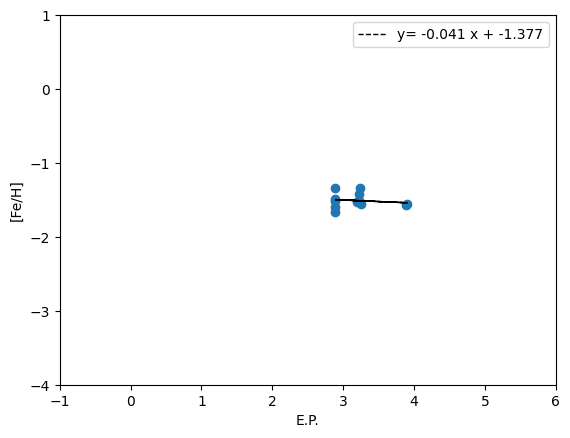

-1.5095384615384615  0.08946186438994731


In [78]:

os.chdir(path_to_output)
t1 = Table.read('stellaFes', format='ascii')
t2 = Table.read('PINOLOS',format='ascii')
def func(x, a, b):
    return b +a*x
eqw=t1['col8']
tag=t1['col9']
col_eqw = Table.Column(name='eqw', data=eqw)
col_tag = Table.Column(name='tag', data=tag)
# t2.add_column(col_eqw)
# t2.add_column(col_tag)

#t2 = Table.read('ressousa.am15at4250g10k2odfnew.dat',format='ascii')

#z=t2['D']


x=t2['col3']
y=t2['col7']
# z=t2['eqw']
fe=t2['col2']
# x=t2['C']
# y=t2['G']
# z=t2['eqw']
# fe=t2['B']




limit=((fe==26.1))
x=x[limit]
y=y[limit]
limit=((y<np.mean(y)+1*np.std(y))&(y>np.mean(y)-1*np.std(y)))
x=x[limit]
y=y[limit]
plt.plot(x,y,"o")
#color=(1/np.max(z),0,0)
popt, pcov = curve_fit(func, x, y,method='lm')
std1=np.std(y-(func(x,*popt)))
mean1=np.mean(y)
plt.plot(x, func(x, *popt),'k--', lw=1., label='y= %5.3f x + %5.3f'% tuple(popt))
plt.axis([-1,6,-4,1])
plt.xlabel('E.P.')
plt.ylabel('[Fe/H]')
#plt.colorbar(label='E.W.')
plt.legend()
plt.show()

print(f"{mean1}  {std1}")


In [ ]:
limit

In [ ]:
print(T_slope)
x = []
y = []
for i in range(trials):
    x.append(T_slope[i][0])
    y.append(T_slope[i][1])
plt.plot(x, y)
plt.axis([3000,12000,-0.5,0])
plt.show()
print()

#derivatina

derivata = np.zeros((trials, 2))

for i in range(1,trials):
    derivata[i]=((T_slope[i][1] - T_slope[i-1][1])/(T_slope[i][0] - T_slope[i-1][0]))

dx = []
dy = []
for i in range(trials):
    dx.append(T_slope[i][0])
    dy.append(derivata[i][1])
plt.plot(dx, dy)
plt.axis([3000,12000,-4,2])
plt.show()

In [ ]:


crea_ATMinterpol(te, ti, -1.6)

1.6807628433027246

A5
B5


In [ ]:
print((temperatura[39]))

14000


In [ ]:
####OLD e funzionante#### togli commenti alla bisogna

# ############## LEGGI LA TEMPERATURA E SELEZIONA DI CONSEGUENZA L'ATMOSFERA ##############
# trials = 30
# temp_log = np.zeros(trials)
# T_slope = np.zeros((trials, 2))
# temp_best_guess1 = 0
# temp_best_guess2 = 0
# temp_best_guess3 = 0
# for i in range(trials):
#     temperatura = [3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000, 12250, 12500, 12750, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000]
#     logg = [0, 0.50000, 1.00000, 1.50000, 2.00000, 2.50000, 3.00000, 3.50000, 4.00000, 4.50000, 5.00000]
#     MH = ["05", "02", "00", "-05", "-10", "-15", "-20"]
#     os.chdir(path_to_atmosphere)
#     with open('ATMslope0T.txt') as atm:
#         t_atmos = repr(atm.read())

#     tmp = t_atmos.split("\\n")
#     tmp = tmp[0].split("'")
#     T_atmos = int(tmp[1])
#     temp = [abs(T_atmos-x) for x in temperatura]
#     guessTemperature = temperatura[temp.index(min(temp))]

#     with open('ATMslopeT.txt') as atm:
#         t_atmosold = repr(atm.read())

#     if guessTemperature == T_atmosold:
#         print(f"FINE, la temperatura migliore è o {guessTemperature} o {T_atmosold}")
#         # comando_bash3 = f"mv PINOLOS {path_to_output}/PINOLOS{guessTemperature}"
#         # os.system(comando_bash3)
#         break

#     tmpold = t_atmosold.split("\\n")
#     tmpold = tmpold[0].split("'")
#     T_atmosold = int(tmpold[1])


#     comando_bash1 = f"cp /home/starcat/Scrivania/ANALISIATM/ATMOSFERE/MH-20/atmoT{guessTemperature}1.0.txt {path_to_abundance}/ModelE"

#     os.system(comando_bash1)


#     ### RUN ABUNDANCE ###

#     os.chdir(path_to_abundance)


#     ! ./abundance -t

#     ### PLOT E ANALISI ###

#     def func(x, a, b):
#         return b +a*x


#     # plt.figure()

#     t1 = Table.read('stellaFes', format='ascii')
#     t2 = Table.read('PINOLOS',format='ascii')
#     comando_bash2 = f"mv PINOLOS {path_to_output}/PINOLOS{guessTemperature}"
#     os.system(comando_bash2)

#     eqw=t1['col8']
#     print(t2)
#     tag=t1['col9']
#     col_eqw = Table.Column(name='eqw', data=eqw)
#     col_tag = Table.Column(name='tag', data=tag)
#     t2.add_column(col_eqw)
#     t2.add_column(col_tag)

#     #t2 = Table.read('ressousa.am15at4250g10k2odfnew.dat',format='ascii')

#     #z=t2['D']


#     x=t2['col3']
#     y=t2['col7']
#     z=t2['eqw']
#     fe=t2['col2']
#     # x=t2['C']
#     # y=t2['G']
#     # z=t2['eqw']
#     # fe=t2['B']




#     limit=((fe==26.0))
#     x=x[limit]
#     y=y[limit]
#     #z=z[limit]


#     # limit=((y<np.mean(y)+2*np.std(y))&(y>np.mean(y)-2*np.std(y)))
#     # x=x[limit]
#     # y=y[limit]
#     #z=z[limit]



#     print(np.mean(y),np.std(y))

#     # plt.plot(x,y,"o")

#     color=(1/np.max(z),0,0)
#     popt, pcov = curve_fit(func, x, y,method='lm')
#     std1=np.std(y-(func(x,*popt)))
#     print(f"deviazione standard = {std1} www")
#     os.chdir('/home/starcat/Scrivania/ANALISIATM/ATMOSFERE/')
#     T_slope[i][0] = int(guessTemperature)
#     T_slope[i][1] = popt[0]

#     if(popt[0]>0): #alza la temperatura
#         tmp_guessTemp = temperatura[temperatura.index(guessTemperature)+1]
#     else:
#         tmp_guessTemp = temperatura[temperatura.index(guessTemperature)-1]

#     temp_log[i] = tmp_guessTemp

#     with open('ATMslope0T.txt', 'w') as atmfile:
#         atmfile.write(str(tmp_guessTemp))

#     with open('ATMslopeT.txt', 'w') as atmfile:
#         atmfile.write(str(guessTemperature))
#     #i = i+1

# print()
# print()
# print()
# print()
# print()
# print()
# print()
# print()
# print()
# print(temp_log)
# print(T_slope)
# # # x=x[limit]
# # # y=y[limit]
# # plt.plot(x, func(x, *popt),'k--', lw=1., label='y= %5.3f x + %5.3f'% tuple(popt))
# # print(guessTemperature)
# # plt.axis([-1,6,-4,1])
# # plt.xlabel('E.P.')
# # plt.ylabel('[Fe/H]')
# # #plt.colorbar(label='E.W.')
# # plt.legend()
# # plt.show()

In [ ]:


os.chdir('C:\\Users\\mtcic\\Documents\\archive')
t11 = Table.read('atmoT40001.0.txt', format='ascii')
t12 = Table.read('atmoT40001.5.txt', format='ascii')
t13 = Table.read('atmoT40002.0.txt', format='ascii')
t14 = Table.read('atmoT40002.5.txt', format='ascii')
t15 = Table.read('atmoT40003.0.txt', format='ascii')
t16 = Table.read('atmoT40003.5.txt', format='ascii')
t17 = Table.read('atmoT40004.0.txt', format='ascii')
t21 = Table.read('atmoT42501.0.txt', format='ascii')
t22 = Table.read('atmoT42501.5.txt', format='ascii')
t23 = Table.read('atmoT42502.0.txt', format='ascii')
t24 = Table.read('atmoT42502.5.txt', format='ascii')
t25 = Table.read('atmoT42503.0.txt', format='ascii')
t26 = Table.read('atmoT42503.5.txt', format='ascii')
t27 = Table.read('atmoT42504.0.txt', format='ascii')
t31 = Table.read('atmoT45001.0.txt', format='ascii')
t32 = Table.read('atmoT45001.5.txt', format='ascii')
t33 = Table.read('atmoT45002.0.txt', format='ascii')
t34 = Table.read('atmoT45002.5.txt', format='ascii')
t35 = Table.read('atmoT45003.0.txt', format='ascii')
t36 = Table.read('atmoT45003.5.txt', format='ascii')
t37 = Table.read('atmoT45004.0.txt', format='ascii')



def magna1(y):
    for j in range(72):
        for k in range(10):
            y[0][0][j][k] = t11[j][k]

    for j in range(72):
        for k in range(10):
            y[0][1][j][k] = t12[j][k]

    for j in range(72):
        for k in range(10):
            y[0][2][j][k] = t13[j][k]

    for j in range(72):
        for k in range(10):
            y[0][3][j][k] = t14[j][k]

    for j in range(72):
        for k in range(10):
            y[0][4][j][k] = t15[j][k]

    for j in range(72):
        for k in range(10):
            y[0][5][j][k] = t16[j][k]

    for j in range(72):
        for k in range(10):
            y[0][6][j][k] = t17[j][k]

def magna2(y):
    for j in range(72):
        for k in range(10):
            y[1][0][j][k] = t21[j][k]

    for j in range(72):
        for k in range(10):
            y[1][1][j][k] = t22[j][k]

    for j in range(72):
        for k in range(10):
            y[1][2][j][k] = t23[j][k]

    for j in range(72):
        for k in range(10):
            y[1][3][j][k] = t24[j][k]

    for j in range(72):
        for k in range(10):
            y[1][4][j][k] = t25[j][k]

    for j in range(72):
        for k in range(10):
            y[1][5][j][k] = t26[j][k]

    for j in range(72):
        for k in range(10):
            y[1][6][j][k] = t27[j][k]

def magna3(y):
    for j in range(72):
        for k in range(10):
            y[2][0][j][k] = t31[j][k]

    for j in range(72):
        for k in range(10):
            y[2][1][j][k] = t32[j][k]

    for j in range(72):
        for k in range(10):
            y[2][2][j][k] = t33[j][k]

    for j in range(72):
        for k in range(10):
            y[2][3][j][k] = t34[j][k]

    for j in range(72):
        for k in range(10):
            y[2][4][j][k] = t35[j][k]

    for j in range(72):
        for k in range(10):
            y[2][5][j][k] = t36[j][k]

    for j in range(72):
        for k in range(10):
            y[2][6][j][k] = t37[j][k]



y = np.zeros((3, 7, 72, 10))
dy = np.zeros((7, 72, 10))

magna1(y)
magna2(y)
magna3(y)


a = []

for i in range(7):
    a.append(y[2][i][70][1])


plt.plot(a)
plt.show()

N_puntiInterpolati = 800

X = []
for i in range(7):
    X.append(1.*i / 2 + 1)
# X = y[:, :, :, 0]
# Y = y[:, :, :, 2]
print(X)
# calculate polynomial
z = np.polyfit(X, np.asarray(a), 6)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(X[0], X[-1], N_puntiInterpolati)
y_new = f(x_new)

plt.plot(X,np.asarray(a),'o', x_new, y_new)
plt.xlim([X[0]-1, X[-1] + 1 ])
plt.show()

print(x_new)

In [75]:
# In sostanza quello che voglio ottenere è una funzione che dato un valore di T, logg e M, crei
# un'atmosfera interpolata. Nello specifico un'atmosfera è definita da 720 parametri.
#Devo muovermi in 3 direzioni, Teff, logg, M
#1) Teff
#Fisso logg e M e carico tutte le atmosfere al variare di Teff
#Togli intestazione e coda, a ogni file di atmosfera rimangono 72 righe con 10 colonne.
#Ognuno di questi 720 parametri deve essere interpolato facendo variare la temperatura
#Creo un array numpy la prima dimensione è l'intervallo di temperatura, da 3500 a 5500 
# a step di 250 sono 9, la gravità superficiale da 0.5 a 5.0 in step da 0.5 sono 10, per
# la metallicità abbiamo da 0.0 a -3.0 in step da -0.5 dunque 7, rimangono le righe 72, e le
# colonne, 10. Se fisso tutti gli indici ottengo uno dei parametri. Se voglio muovermi solo lungo
# la temperatura fisso tutti gli indici tranne la temperatura. Adesso dovrò accedere ad uno ad uno 
# ai singoli parametri, se faccio così posso interpolare con un polinomio di ordine n.
# questo processo mi crea un array unidimensionale di N elementi (a scelta +alto e +punti, come
# inizio faccio dimensione(temperatura) * 10 = 130) ognuno dei quali corrisponde al valore del
# parametro j,k,l,m esimo alla temperatura T. Dove T adesso è diventato l'intervallo iniziale
# ma campionato con step di 250/10=25. Dunque io fornisco una T qualunque alla funzione. Tipo 
#4132, allora la temperatura più vicina è 4125, questa sarà la temperatura scelta per l'interpolazione
#se chiamo x questa temperatura restituirò dunque y_j,k,l,m = f(x)


# + f"MH{metal}"

temperat = 4250
loggh = 1.0
metallu = -1.61
b = interpolaT(temperat, loggh, metallu)
T_close=find_closest(temperat, T_EFF_Nint)
logg_close=find_closest(loggh, LOGG_Nint)
M_close=find_closest(metallu, MH_Nint)
differenze = differenza_INT_grid(temperat, loggh, metallu)

b = interpolalog(temperat, loggh, metallu, differenze)





In [76]:


sposta(b, path_to_output, path_to_abundance, "ModelE")
lanciaAbundance()
sposta("PINOLOS", path_to_abundance, path_to_output, "PINOLOS")